# Reactor Kinetics

Please indicate your name below, since you will need to submit this notebook completed latest the day after the datalab.

Don't forget to save your progress during the datalab to avoid any loss due to crashes.

In [1]:
name='Jeppe'

In this notebook, we will try to get a hands-on feeling for how the neutron density in a reactor can change with time, given a certain change in reactivity. As you saw in the lecture, this behaviour may to first order be described by the point kinetics equation. We will first look at the most basic assumption about neutron generation in a reactor, assuming that all neutrons are produced _at the moment of fission_. These are the prompt neutrons. After that, we will study the infuence of a small but very important portion of the neutron population: the delayed neutrons. To describe the time dependence of the neutron density, we'll need to use differential equations. In the lecture, we have looked at analytical solutions to these, and in this notebook, we will opt for two different numerical approaches: using a numerical solver implemented in Python and using Monte Carlo methods. Both of these methods are used in many real-life applications when it is impossible to find an analytic solution and/or the system becomes more complex. Thereore, these are skills that are applicable not only in reactor physics, but also in a broader context within science and engineering.

Towards the end of the notebook, we will look at the inhour equation, which was studied during the lecture. The inhour equation tells us something about the time dependence of the neutron density (or reactor power) as a function of the reactivity change. In particular, it tells us the time constants involved in the neutron density change. To find those from the inhour equation, we will use numerical tools for root finding. Also this is a technique which is very useful in a wide range of applications.

### Reactor with only prompt neutrons
Let's start with the most basic case. We assume that the reactor is critical (i. e. $k = 1$, $\rho = 0$), and that all neutrons used to sustain the chain reaction are prompt. Each neutron will "live" on average a time $l$ between its generation and ultimate absorption. For a thermal reactor, $l \simeq 10^{-4}$ s, and for a fast reactor, $l \simeq 10^{-7}$ s. As shown during the lecture, setting up the neutron diffusion under these conditions yields an expression for the rate of thange in the neutron density $n$:
\begin{equation}
\frac{dn}{dt} = \left ( \frac{k-1}{l} \right ) n(t)
\end{equation}

Now, what does this differential equation tell us? It tells us that the rate of change depends on how many neutrons there are presently, and on the time constant $(k-1)/l$. The time constant tells us at what rate change in $n$ will occur, _given the current value of $n$_. In fact, the probability for a neutron to be added or removed from the system within a short time $\Delta t$ is given by:
\begin{equation}
Prob(\Delta t) = \Delta t\left | \frac{k-1}{l} \right |
\end{equation}

This probability is independent of $n$, but the _total_ rate of change will depend on $n$. We are now interested in describing how $n$ actually depends on the time $t$, so we must solve this differential equation. First, we will do this using a Monte Carlo approach, which gives a rather intuitive feeling for what is going on. Consider a reactor with a neutron density $n(0)$ at time $t = 0$, where $k$ is now increased or decreased (away from 1). The value of $k$ will determine whether we are considering an increasing or decreasing neutron density. The neutron density _after_ $\Delta t$ (that is, at time step $i+1$) is now given by:
\begin{equation}
\frac{\Delta n}{\Delta t} = \left ( \frac{k-1}{l} \right ) n_i \Rightarrow \frac{\Delta n}{n_i} = \left ( \frac{k-1}{l} \right )\Delta t,
\end{equation}
where you may recognise our probability on the right hand side. Although we could in principle sample the decay/production probability for each neutron in the system, this could lead to numerical problems (if the population grows exponentially). Therefore, we will start by using Monte Carlo methods to sample the right hand side of the above equation. This describes the _fractional_ increase in the neutron population, so in our solution we will study the neutron population _relative to the population at time $t = 0$_. Nonetheless, because we use Monte Carlo methods to sample the probability distribution above, there will be statistical fluctuations depending on how many samples we use to estimate it.

#### Experiment 1: Prompt neutron kinetics using Monte Carlo
First, we want to use Monte Carlo to model the change in neutron population. The idea of this task is that you should see the effect of changing the $k$ value, as well as the statistical properties of the Monte Carlo approach.

We first need to set up some constants for the problem we are modelling. We use $l = 10^{-4}$ s and some different values of $k$, namely 0.999, 0.99, 1.01 and 1.001.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

l = 1e-4
k = np.array([0.99, 0.999, 1.001, 1.01])

Now, define the $\Delta t$ steps to use in the problem. We use a value of $\Delta t = 0.001$ s (you can try changing this and see what happens), and want to run up to a time of 5 seconds. We also specify how many Monte Carlo samples to draw per time step. For the moment, set this to 10:

In [3]:
Delta_t = 0.001
t = np.arange(0, 5, Delta_t)

N_samples = 10

Now, we set up the actual sampling algorithm. We'll need to sample random values from a uniform probability distribution between 0 and 1. The change will be accepted if the sampled value is smaller than $\Delta t\left | \frac{k-1}{l} \right |$:

In [4]:
def MC_sampler(t, parameters, N_samples):
    l, k = parameters
    
    Delta_t = t[1] - t[0]               ## we assume that all time steps are the same width
    
    probability = np.abs((k-1)/l)*Delta_t

    if (k >= 1.):
        increase_or_decrease = +1
    else:
        increase_or_decrease = -1
    
    n_rel = np.array([1.])           ## Array to store the neutron population at different time steps, *relative to the population at t=0*. So, need to initialise with 1 (this is the relative population at t=0)
    
    for time_step in(t[1:]):
        n_rel_latest = n_rel[-1]
        
        samples = np.random.uniform(0, 1, size = N_samples)
        N_accepted = np.sum(samples < probability)          ## Count how many of the drawn values were accepted.
        
        percentage_accepted = N_accepted/float(N_samples)
        
        n_rel = np.append(n_rel, n_rel_latest*(1. + increase_or_decrease*percentage_accepted))   ## this time window, the neutron density increased by a fraction determined by how many samples were accepted
        
    return n_rel

We now have a function to sample from the distribution describing addition or removal of neutrons. You'll notice that the number of samples drawn is not necessarily the same as the actual number of neutrons - because we in the end calculate the change relative to the total neutron population, the accepted fraction will describe the relative increase/decrease in the population. Now, we are ready to plot the relative change in the neutron density as a function of time. Because 
we specified four different possible $k$ values, you will get four lines in the plot.

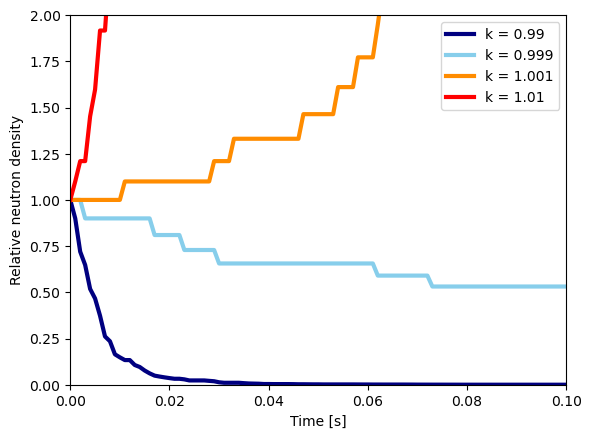

In [5]:
n_rel_MC = np.zeros(shape=(len(k), len(t)))

linecolours = ['navy', 'skyblue', 'darkorange', 'red']

for i, k_current in enumerate(k):
    parameters = [l, k_current]

    n_rel_MC[i] = MC_sampler(t, parameters, N_samples)

    plt.plot(t, n_rel_MC[i], linewidth=3, label='k = ' + str(k_current), color=linecolours[i])

plt.xlim(0, 0.1)
plt.ylim(0, 2)
plt.xlabel('Time [s]')
plt.ylabel('Relative neutron density')
plt.legend()

#### Exercise 1: Prompt neutron kinetics using analytical solution
You'll notice that the output of the Monte Carlo simulation is quite "noisy". That is, the output is not a smooth function. We may actually check how this compares with the analytic solution to this problem (as we derived in the lecture). So, now it's up to you to define the function for $n$ as a function of $t$ when only considering prompt neutrons. Remember that we are talking about relative numbers, so you should write the function for $n(t)/n(0)$. Please fill in the missing parts of the equation below, and run the program. The program will plot the analytical solution together with the MC solution. Note that every time you re-run the code below, a new call is made to the MC_sampler, so you will get different results from the MC every time.

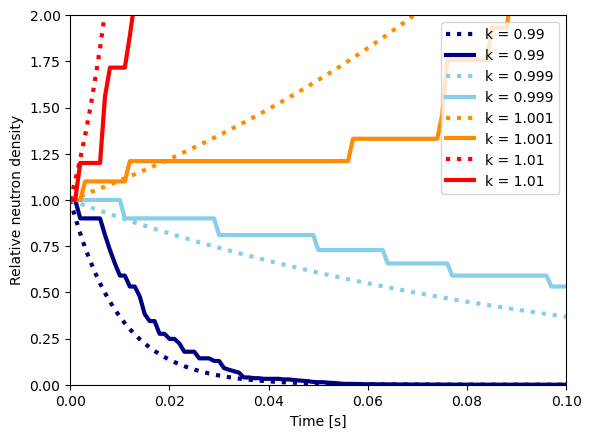

In [6]:
def prompt_analytical(t, parameters):
    l, k = parameters
    T = l/(k-1)
    n_rel = np.exp(t/T)

    return n_rel


n_rel_analytical = np.zeros(shape=(len(k), len(t)))

for i, k_current in enumerate(k):
    parameters = [l, k_current]

    n_rel_analytical[i] = prompt_analytical(t, parameters)
    n_rel_MC[i] = MC_sampler(t, parameters, N_samples)

    plt.plot(t, n_rel_analytical[i], linewidth=3, linestyle=':', label='k = ' + str(k_current), color=linecolours[i])
    plt.plot(t, n_rel_MC[i], linewidth=3, label='k = ' + str(k_current), color=linecolours[i])

plt.xlim(0, 0.1)
plt.ylim(0, 2)
plt.xlabel('Time [s]')
plt.ylabel('Relative neutron density')
plt.legend()


Here, the dotted lines are the analytical solutions. You notice that the agreement is pretty good! The fact that the Monte Carlo solution is more "noisy" is due to the fact that it describes the random nature of sampling the probability distribution. It was stated above that the number of samples drawn can influence the result of the Monte Carlo simulation, so let's try some different values for that parameter. We now fix $k$ to 1.001.

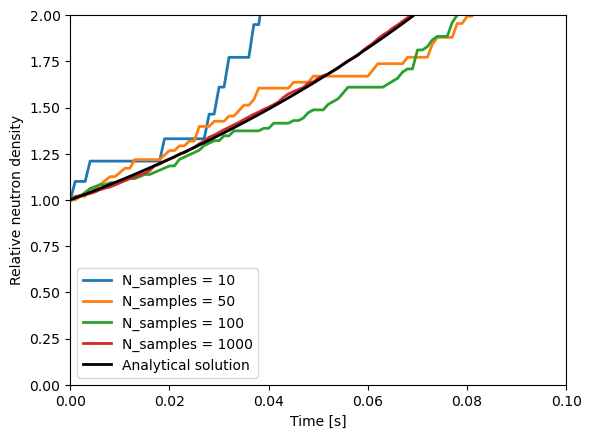

In [7]:
N_samples = [10, 50, 100, 1000]
k = 1.001

parameters = [l, k]

for N_samples_current in N_samples:
    n_rel_MC = MC_sampler(t, parameters, N_samples_current)

    plt.plot(t, n_rel_MC, linewidth = 2, label='N_samples = ' +str(N_samples_current))

n_rel_analytical = prompt_analytical(t, parameters)
plt.plot(t, n_rel_analytical, linewidth = 2, color='black', label='Analytical solution')

plt.xlim(0, 0.1)
plt.ylim(0, 2)
plt.xlabel('Time [s]')
plt.ylabel('Relative neutron density')
plt.legend()

Try to re-run the above script a few times - you'll notice a few things:
* you get different results every time
* as the number of MC samples increases, the solution converges towards the analytic solution

These results are again due to the stochastic nature of the problem. We can finally run several iterations with two values of N_samples (100 and 1000) to study how much the solution differs every time:

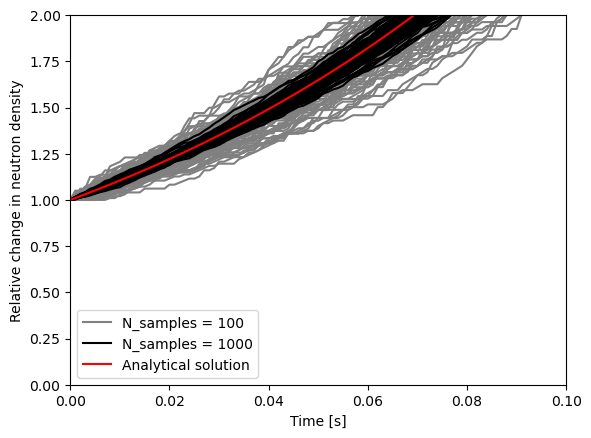

In [8]:
N_iterations = 100
N_samples = [100, 1000]

linecolor = {100: 'gray', 1000: 'black'}

for N_samples_current in N_samples:
    for i in range(N_iterations):
        n_rel_MC = MC_sampler(t, parameters, N_samples_current)

        if (i == 0):                 ## for drawing labels only once
            plt.plot(t, n_rel_MC, color=linecolor[N_samples_current], label='N_samples = ' + str(N_samples_current))
        else:
            plt.plot(t, n_rel_MC, color=linecolor[N_samples_current])

            
plt.plot(t, n_rel_analytical, color='red', label='Analytical solution')    ## Include the analytic solution

plt.xlim(0, 0.1)
plt.ylim(0, 2)
plt.xlabel('Time [s]')
plt.ylabel('Relative change in neutron density')
plt.legend()

This nicely shows how you can estimate the uncertainties in your Monte Carlo simulation: the variance of the output gives a measure of this, and the variance decreases as you sample the underlying probability distribution more times. As a sidenote, uncertainty quantification using Monte Carlo techniques is a very versatile tool which may be applied to complex systems where no analytic expression for uncertainty propagation is available.

### Reactor with one effective group of delayed neutrons
Now we move to the more realistic situation of including one effective group of delayed neutrons. As discussed in the lecture, we then end up with two coupled differential equations:
\begin{equation}
\frac{dn}{dt} = \left( \frac{\rho - \beta}{\Lambda} \right) n(t) + \langle \lambda \rangle C(t)
\end{equation}

\begin{equation}
\frac{d C}{d t} = \frac{\beta}{\Lambda} n(t) - \langle \lambda \rangle C(t)
\end{equation}

Here, $\langle \lambda \rangle$ is the one-group effective precursor decay constant and $\beta$ is the number of delayed neutrons as a fraction of all neutrons in the system. 

#### Exercise 2:  One effective group of delayed neutrons, numerical solution
You will now solve the above system of differential equations using the differential-equation solver solve_ivp, part of the Python library SciPy. By now, you should have experience with that from another datalab. The documentation for this solver may be found at https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html.

We first define the necessary parameters. Note that we define the beta and lambda values for all six groups of delayed neutrons as during the lecture. Then it is your first task to calculate the effective values for the one-group approximation:

In [9]:
from scipy.integrate import solve_ivp

rho = 0.001                 ## the reactivity change
l = 1e-4                    ## For thermal reactor
Lambda = l/1.               ## the mean neutron generation time (Lambda = l/k). Assuming k ~ 1 initially, Lambda ~ l

beta_six_gr = np.array([0.000215, 0.001424, 0.001274, 0.002568, 0.000748, 0.000273])
half_life_six_gr = np.array([55.72, 22.72, 6.22, 2.30, 0.610, 0.230])
lambda_six_gr = np.log(2.)/half_life_six_gr

## Here, enter your calculations to get the beta and lambda values for the one-group approximation:

beta_tot = sum(beta_six_gr) #enter your code here. This should be the sum of the betas for the different groups
lambda_one_gr = 1 / (1/beta_tot * np.sum(beta_six_gr/lambda_six_gr))  # enter code here. This should be the averages 1-group delayed neutron decay constant

Then, we define the actual system of differential equations:

In [10]:
def one_group_system(t, z, rho, beta_tot, Lambda, lambda_one_gr):
        
    n, C = z
    
    # Here, enter the one-group point kinetics equations (i. e. dn/dt and dC/dt):
    dn_dt = (rho-beta_tot)/Lambda * n + lambda_one_gr*C
    dC_dt = beta_tot/Lambda * n - lambda_one_gr*C
    
    return [dn_dt, dC_dt]

To solve the system of differential equations, we need to provide initial conditions, i. e. $n(0)$ and $C(0)$, along with a time axis along which to solve the system. Note that we put $n(0) = 1$ because again we are just interested in the relative change relative to $n(0)$ (so $n(0)$ is arbitrary in this particular way of doing things). You should also enter the expression for $C(0)$, which is a combination of $\beta$, $\lambda$, $\Lambda$ and $n(0)$ as discussed in the lecture:

In [11]:
n_0 = 1
C_0 = beta_tot/(lambda_one_gr*Lambda)*n_0 # enter code here, i.e. the initial condition on C (C at time 0)

t_numerical = np.linspace(0, 50, 1000)   

Now, we may use the solver to solve this system of differential equations:

In [12]:
sol = solve_ivp(fun=one_group_system, t_span=[t_numerical[0], t_numerical[-1]], y0=[n_0, C_0], args=(rho, beta_tot, Lambda, lambda_one_gr), dense_output=True)          ## dense_output allows you to solve explicitly for the whole t vector later


solution_one_gr = sol.sol(t_numerical)

n_numerical_one_gr = solution_one_gr[0]
C_numerical_one_gr = solution_one_gr[1]

The solution may be plotted:

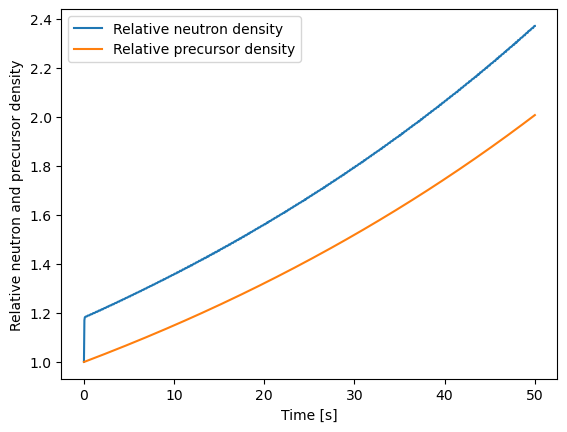

In [13]:
plt.plot(t_numerical, n_numerical_one_gr/n_0, label='Relative neutron density')
plt.plot(t_numerical, C_numerical_one_gr/C_0, label='Relative precursor density')

plt.xlabel('Time [s]')
plt.ylabel('Relative neutron and precursor density')
plt.legend()

#### Experiment 2: One effective group of delayed neutrons using Monte Carlo
We can also solve the differential equation using Monte Carlo, as we did for the prompt neutrons. Just as before, we define the probabilities per time $\Delta t$, draw a number of samples for each time step and calculate the average. First need to define a new Monte Carlo solver, for this more complex situation. Note in the system of equations above that we can actually identify four probabilities:
\begin{equation}
Prob(\Delta t)_1 = \Delta t\left | \frac{\rho-\beta}{\Lambda} \right |
\end{equation}
\begin{equation}
Prob(\Delta t)_2 = \Delta t | \langle \lambda \rangle |
\end{equation}
\begin{equation}
Prob(\Delta t)_3 = \Delta t\left | \frac{\beta}{\Lambda} \right |
\end{equation}
\begin{equation}
Prob(\Delta t)_4 = \Delta t | \lambda |
\end{equation}

The first defines the probability that a prompt neutron is produced or absorbed, the second that a delayed neutron is produced in a precursor decay, the third that a precursor is formed in fission and the fourth that a precursor decays. In each time step, we need to sample these four probabilities and add up according to the form of the differential equation. We thus end up with:
\begin{equation}
\Delta n = \pm Prob(\Delta t)_1 n_i + Prob(\Delta t)_2 C_i
\end{equation}
\begin{equation}
\Delta C = Prob(\Delta t)_3 n_i - Prob(\Delta t)_4 C_i,
\end{equation}
where the $\pm$ sign depends on the value of $\rho$ relative to $\beta$. Note that you'll need to explicitly define the initial value $n(0)$ (although we will later divide by this and $C(0)$ to get the relative quantities). We use the same values for $n(0)$ and $C(0)$ as you used under Exercise 2 above. We define this sampler:

In [14]:
def MC_sampler_one_gr(t, parameters, N_samples):
    n_0, C_0, rho, beta, Lambda, lambda_one_gr = parameters
    
    Delta_t = t[1] - t[0]               ## we assume that all time steps are the same width
    
    ## Note that we write out these terms explicitly - could be written in a more concise form, but written like this for clarity.
    probability_1 = np.abs((rho-beta)/Lambda)*Delta_t       ## we assume that all time steps are the same width
    probability_2 = np.abs(lambda_one_gr)*Delta_t
    probability_3 = np.abs(beta/Lambda)*Delta_t
    probability_4 = np.abs(lambda_one_gr)*Delta_t
    
    
    if (rho >= beta):
        increase_or_decrease = +1
    else:
        increase_or_decrease = -1
    
    n = np.array([n_0])           ## Array to store the neutron population at different time steps, *relative to the population at t=0*. So, need to initialise with 1 (this is the relative population at t=0)
    C = np.array([C_0])
    
    
    for time_step in(t[1:]):
        n_latest = n[-1]
        C_latest = C[-1]

        samples_1 = np.random.uniform(0, 1, size = N_samples)
        samples_2 = np.random.uniform(0, 1, size = N_samples)
        samples_3 = np.random.uniform(0, 1, size = N_samples)
        samples_4 = np.random.uniform(0, 1, size = N_samples)        
        
        N_accepted_1 = np.sum(samples_1 < probability_1)          ## Count how many of the drawn values were accepted.
        N_accepted_2 = np.sum(samples_2 < probability_2)
        N_accepted_3 = np.sum(samples_3 < probability_3)
        N_accepted_4 = np.sum(samples_4 < probability_4)
        
        
        percentage_accepted_1 = N_accepted_1/float(N_samples)
        percentage_accepted_2 = N_accepted_2/float(N_samples)
        percentage_accepted_3 = N_accepted_3/float(N_samples)
        percentage_accepted_4 = N_accepted_4/float(N_samples)
        
        n = np.append(n, n_latest + increase_or_decrease*n_latest*percentage_accepted_1 + percentage_accepted_2*C_latest)   ## this time window, the neutron density increased by a fraction determined by how many samples were accepted
        C = np.append(C, C_latest + percentage_accepted_3*n_latest - percentage_accepted_4*C_latest)
        
    return [n, C]

You'll notice that we have defined four "transition probabilities", one for each term in the two coupled equations. This corresponds to looking at both neutron and precursor production and loss independently (since there is an ensemble of particles), and then determine the average changes. We can plot and compare with the numerical solutions obtained above (note: you might have to wait a while for these results):

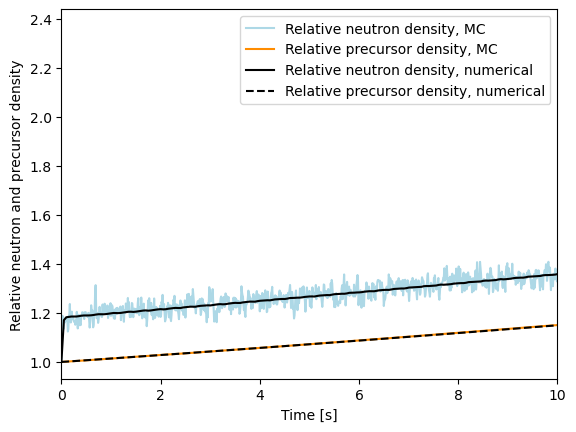

In [15]:
parameters = [n_0, C_0, rho, beta_tot, Lambda, lambda_one_gr]
N_samples = 1000000

Delta_t = 0.01
t_MC = np.arange(0, 10, Delta_t)

n, C = MC_sampler_one_gr(t_MC, parameters, N_samples)





plt.plot(t_MC, n/n_0, label='Relative neutron density, MC', color='lightblue')
plt.plot(t_MC, C/C_0, label='Relative precursor density, MC', color='darkorange')

plt.plot(t_numerical, n_numerical_one_gr/n_0, label='Relative neutron density, numerical', color='black')
plt.plot(t_numerical, C_numerical_one_gr/C_0, label='Relative precursor density, numerical', linestyle='--', color='black')

plt.xlabel('Time [s]')
plt.ylabel('Relative neutron and precursor density')
plt.xlim(0, 10)
plt.legend()


Pretty nice agreement, right? Of course, the random variations are visible in the Monte Carlo results. You can try to vary the number of MC samples drawn (i. e. N_samples) to see the result converge to the analytical solution.

### Reactor with six effective groups of delayed neutrons
Now we move to the even more realistic situation of including six effective groups of delayed neutrons. As discussed in the lecture, we then end up with seven coupled differential equations:
\begin{equation}
\frac{dn}{dt} = \left( \frac{\rho - \beta}{\Lambda} \right) n(t) + \sum_{i=1}^6 \lambda_i C_i(t)
\end{equation}

\begin{equation}
\frac{d C_i}{d t} = \frac{\beta_i}{\Lambda} n(t) - \lambda_i C_i(t)
\end{equation}

#### Exercise 3: Six effective groups of delayed neutrons, numerical solution
Again, we start by solving this system using the differential-equation solver solve_ivp, part of the Python library SciPy.

We first define the necessary parameters:



In [16]:
import numpy as np
from scipy.integrate import solve_ivp

rho = 0.001                 ## the reactivity change
Lambda = 1e-4               ## the mean neutron generation time (Lambda = l/k)

beta_six_gr = np.array([0.000215, 0.001424, 0.001274, 0.002568, 0.000748, 0.000273])
half_life_six_gr = np.array([55.72, 22.72, 6.22, 2.30, 0.610, 0.230])
lambda_six_gr = np.log(2.)/half_life_six_gr

Then, define the system of differential equations:

In [17]:
def six_group_system(t, z, rho, beta_six_gr, Lambda, lambda_six_gr):
        
    n, C1, C2, C3, C4, C5, C6 = z
    Cs = [C1, C2, C3, C4, C5, C6]
    beta_tot = sum(beta_six_gr)
    
    ## Here, enter the six-group point kinetics equations (i. e. dn/dt, dC1/dt, dC2_dt, ...):
    dn_dt = (rho - beta_tot)/Lambda * n + np.sum(lambda_six_gr*Cs)
    dC1_dt = beta_six_gr[0]/Lambda*n - lambda_six_gr[0]*C1
    dC2_dt = beta_six_gr[1]/Lambda*n - lambda_six_gr[1]*C2
    dC3_dt = beta_six_gr[2]/Lambda*n - lambda_six_gr[2]*C3
    dC4_dt = beta_six_gr[3]/Lambda*n - lambda_six_gr[3]*C4
    dC5_dt = beta_six_gr[4]/Lambda*n - lambda_six_gr[4]*C5
    dC6_dt = beta_six_gr[5]/Lambda*n - lambda_six_gr[5]*C6
    
    return [dn_dt, dC1_dt, dC2_dt, dC3_dt, dC4_dt, dC5_dt, dC6_dt]

To solve the system of differential equations, we need to provide initial conditions, i. e. $n(0)$, $C_1(0)$, $C_2(0)$ etc, along with a time axis along which to solve the system. Note that we put $n(0) = 1$ because again we are just interested in the relative change relative to $n(0)$ (so $n(0)$ is arbitrary in this particular way of doing things). You should also enter the expressions for $C_1(0)$, $C_2(0)$, $C_3(0)$, $C_4(0)$, $C_5(0)$ and $C_6(0)$, which are combinations of $\beta$, $\lambda$, $\Lambda$ and $n(0)$. You should be able to figure these out based on what we discussed in the lecture:

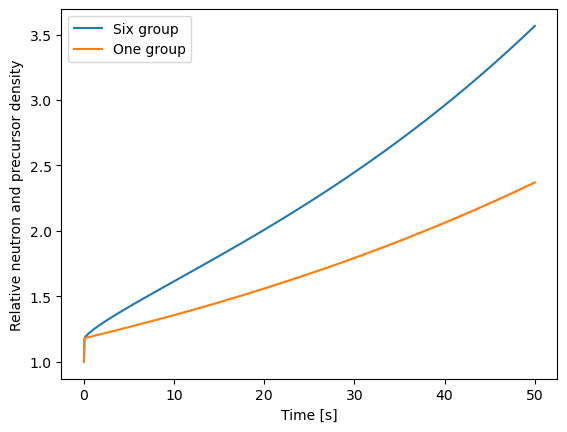

In [18]:
Lambda = 1e-4 # fast reactor
n_0 = 1
C1_0 = beta_six_gr[0]/(lambda_six_gr[0]*Lambda)*n_0
C2_0 = beta_six_gr[1]/(lambda_six_gr[1]*Lambda)*n_0
C3_0 = beta_six_gr[2]/(lambda_six_gr[2]*Lambda)*n_0
C4_0 = beta_six_gr[3]/(lambda_six_gr[3]*Lambda)*n_0
C5_0 = beta_six_gr[4]/(lambda_six_gr[4]*Lambda)*n_0
C6_0 = beta_six_gr[5]/(lambda_six_gr[5]*Lambda)*n_0

t_numerical = np.linspace(0, 50, 1000)

solution = solve_ivp(fun=six_group_system, t_span=[t_numerical[0], t_numerical[-1]], y0=[n_0, C1_0, C2_0, C3_0, C4_0, C5_0, C6_0], args=(rho, beta_six_gr, Lambda, lambda_six_gr), dense_output=True,rtol=1e-6)          ## dense_output allows you to solve explicitly for the whole t vector later


solution_six_gr = solution.sol(t_numerical)


n_numerical_six_gr = solution_six_gr[0]
C1_numerical_six_gr = solution_six_gr[1]
C2_numerical_six_gr = solution_six_gr[2]
C3_numerical_six_gr = solution_six_gr[3]
C4_numerical_six_gr = solution_six_gr[4]
C5_numerical_six_gr = solution_six_gr[5]
C6_numerical_six_gr = solution_six_gr[6]

plt.plot(t_numerical, n_numerical_six_gr/n_0, label='Six group')
plt.plot(t_numerical, n_numerical_one_gr/n_0, label='One group')

plt.xlabel('Time [s]')
plt.ylabel('Relative neutron and precursor density')
plt.legend()

Finally, you should try to think about how the results would change if you consider a fast reactor instead of a thermal reactor. Which parameters will change? How will this change the behaviour and operation of the reactor? You can even try to modify these parameters in the code above to investigate these effects. Enter your thoughts below.

(space for you to enter text)

### The inhour plot
#### Exercise 4: Roots of the inhour equation
The final task in this notebook is to calculate the roots to the inhour plot. In the lecture, you have seen that the inhour plot is a way for us to find the time constants determining the behaviour of the system under different reactivity changes. First, we want to produce the inhour equation as was done for the lecture notes. Note that we consider the case of six groups of delayed neutrons. Here, you should enter the inhour equation.

C:\Users\Jeppe\AppData\Local\Temp\ipykernel_30192\1766893490.py:7: RuntimeWarning: divide by zero encountered in divide
  rho = s*l/(s*l + 1) + 1/(1 + s*l) * ( (s*b1/(s+l1))\
C:\Users\Jeppe\AppData\Local\Temp\ipykernel_30192\1766893490.py:7: RuntimeWarning: invalid value encountered in add
  rho = s*l/(s*l + 1) + 1/(1 + s*l) * ( (s*b1/(s+l1))\


Text(0, 0.5, '$\\rho(s)$')

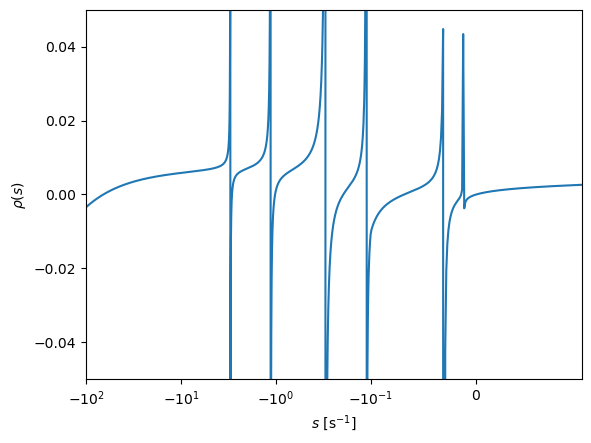

In [19]:
def six_group_inhour(s, l, beta, lambda_six_gr):
    ## Enter your code for calculating the six-group inhour equation, as discussed in the lecture. This function should return rho(s).
    
    ## Enter your code here:
    b1, b2, b3, b4, b5, b6 = beta_six_gr
    l1, l2, l3, l4, l5, l6 = lambda_six_gr
    rho = s*l/(s*l + 1) + 1/(1 + s*l) * ( (s*b1/(s+l1))\
                                      + (s*b2/(s+l2))\
                                      + (s*b3/(s+l3))\
                                      + (s*b4/(s+l4))\
                                      + (s*b5/(s+l5))\
                                      + (s*b6/(s+l6)) )
    return rho
### the function should return rho(s)

s = np.linspace(-10000, 10000, 20000000)     ## define the s space

l = 1e-4      ## prompt neutron lifetime



inhour_plot = six_group_inhour(s, l, beta_six_gr, lambda_six_gr)


plt.plot(s, inhour_plot)

plt.ylim(-0.05, 0.05)
plt.xlim(-100, 0.1)
plt.xscale('symlog', linthresh=0.1)

plt.xlabel('$s$ [s$^{-1}$]')
plt.ylabel(r'$\rho(s)$')


As shown in the lecture, the task is now to first set the reactivity change $\rho_0$ we are interested in. That will become a horizontal line in this diagram. After that, we want to find the roots, i. e. the values of $s$ at which $\rho(s) = \rho_0$. To do this, we will use the numerical root-finder root_scalar, again part of the SciPy library. As is normally done for root finders, we have to re-write the expression we want to analyse so that the root is at $y = 0$. That is, we have to feed $\rho(s) - \rho_0$ into the root-finder. First we define $\rho_0$, i.e. our reactivity change. Then, define the function $\rho(s) - \rho_0$:

In [20]:
rho_0 = 0.001

def inhour_shifted(s, l, beta_six_gr, lambda_six_gr, rho_0):
    rho = six_group_inhour(s, l, beta_six_gr, lambda_six_gr)
    
    return (rho - rho_0)

Now, we can define the root_scalar solver, and send the shifted function into that:

In [21]:
from scipy import optimize

solution = optimize.root_scalar(inhour_shifted, args=(l, beta_six_gr, lambda_six_gr, rho_0), bracket=[0, 300], method='brentq')

print(solution)

      converged: True
           flag: converged
 function_calls: 13
     iterations: 12
           root: 0.018196042549633307


The result here is a root, but only one of the seven roots to this equation! You'll notice that we have defined the "bracket" argument in the solver to be above zero. That is because this type of root-finder needs to surround a single root. So, we need to repeat the process seven times to find all seven roots of the inhour equation. To do that, we need to know something about which $s$ ranges to investigate. From the lecture, we know that the asymptotic behaviour of the inhour equation can be found at $s = -\lambda_1, -\lambda_2, ..., -1/l$. From knowing this, create a code to find the root in each of these intervals:

In [22]:
bl = [-1./l, -lambda_six_gr[5], -lambda_six_gr[4], -lambda_six_gr[3], -lambda_six_gr[2], -lambda_six_gr[1], -lambda_six_gr[0],1] 


roots = []
for i in range(len(bl)-1):
    solution = optimize.root_scalar(inhour_shifted, args=(l, beta_six_gr, lambda_six_gr, rho_0), bracket=[bl[i] - bl[i]/100, bl[i+1] + bl[i+1]/100], method='brentq', xtol=1e-15)
    roots.append(solution.root)

print('roots:',roots) ## Print out the solution

roots: [-55.56225201565817, -2.878148438840278, -1.0015083594024472, -0.18355510947482157, -0.05992162611948812, -0.013630674027553746, 0.018196042549633976]


The change in neutron population will be described as a sum of exponentials on the form $\exp[s_i t]$. Please enter the seven roots you have identified in the list below (note that the indexing of the roots is reversed compared to what you print above):

$s_1 =$

$s_2 =$

$s_3 =$

$s_4 =$

$s_5 =$

$s_6 =$

$s_7 =$